## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [23]:
#data_path = '/content/drive/MyDrive/colab-datasets/hotdog_nothotdog'
data_path = 'projects/hotdogNotdog/hotdog_nothotdog'

In [19]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [20]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [24]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [25]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

ValueError: num_samples should be a positive integer value, but got num_samples=0

Let's look at some images from our data

In [ ]:
print(len(trainset))

2047


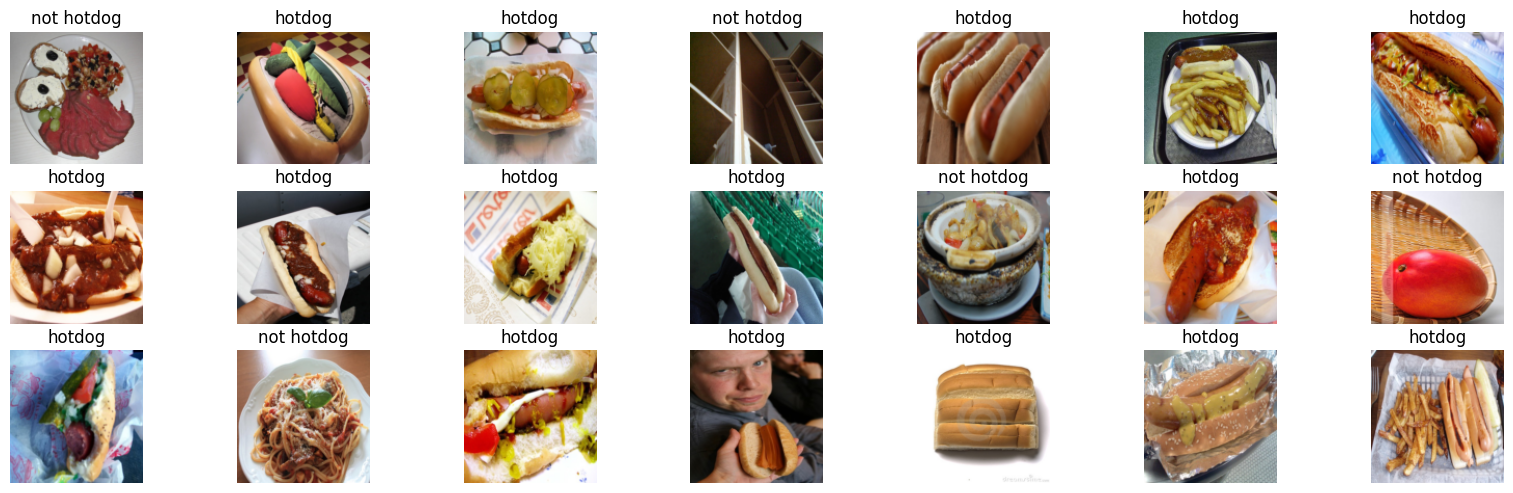

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)

        self.dropout = nn.Dropout(0.2)

        # updated fc1 in_features for 128x128 input
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [ ]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.744	 test: 0.576	 Accuracy train: 64.9%	 test: 70.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.752	 Accuracy train: 75.3%	 test: 65.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.491	 test: 0.515	 Accuracy train: 76.6%	 test: 75.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.425	 test: 0.546	 Accuracy train: 80.8%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.400	 test: 0.509	 Accuracy train: 82.2%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.334	 test: 0.578	 Accuracy train: 85.5%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.315	 test: 0.575	 Accuracy train: 86.0%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.232	 test: 0.633	 Accuracy train: 91.3%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.187	 test: 0.651	 Accuracy train: 93.0%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.138	 test: 0.753	 Accuracy train: 95.0%	 test: 74.4%


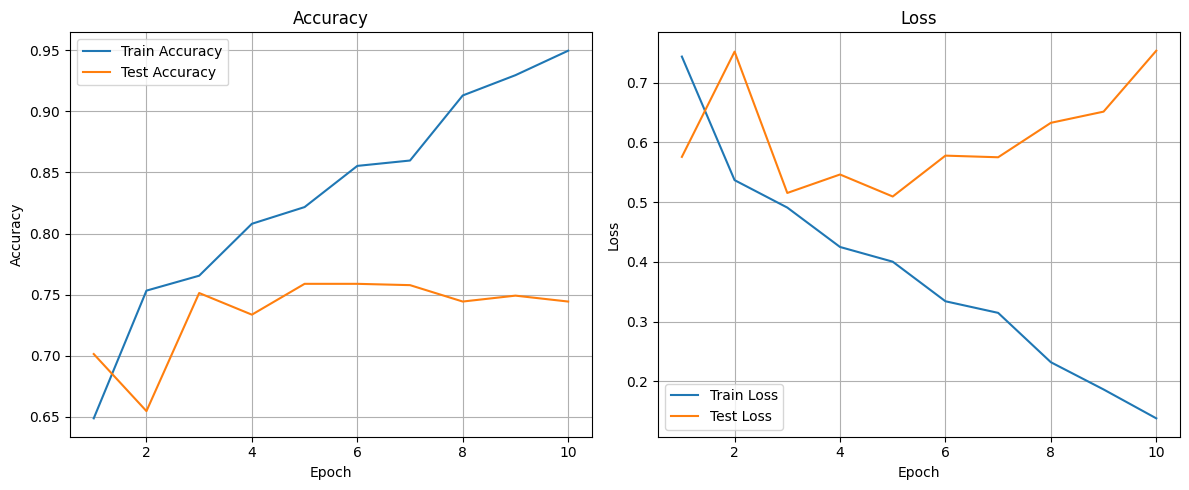

In [ ]:
num_epochs = 10
out_dict = train(model, optimizer, num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy ---
ax[0].plot(range(1, num_epochs + 1), out_dict['train_acc'], label="Train Accuracy")
ax[0].plot(range(1, num_epochs + 1), out_dict['test_acc'], label="Test Accuracy")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()
ax[0].grid(True)

# --- Loss ---
ax[1].plot(range(1, num_epochs + 1), out_dict['train_loss'], label="Train Loss")
ax[1].plot(range(1, num_epochs + 1), out_dict['test_loss'], label="Test Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()